<a href="https://colab.research.google.com/github/claudia-viaro/optimal_stopping-switching/blob/main/optimal_stopping/original_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import torch.optim as optim
from google.colab import files
import helper
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch.utils.data as tdata

In [54]:
class Model:
  def __init__(self, drift, sigma, delta, spot, nb_stocks,
               nb_paths, nb_dates, maturity, dividend=0):

    self.drift = drift - dividend
    self.rate = drift
    self.delta = delta
    self.dividend = dividend
    self.sigma = sigma
    self.spot = spot
    self.nb_stocks = nb_stocks
    self.nb_paths = nb_paths
    self.nb_dates = nb_dates
    self.maturity = maturity
    self.dt = self.maturity / self.nb_dates
    self.df = math.exp(-self.rate * self.dt)

  def disc_factor(self, date_begin, date_end):
    time = (date_end - date_begin) * self.dt
    return math.exp(-self.drift * time)

  def drift_fct(self, x, t):
    raise NotImplemented()

  def diffusion_fct(self, x, t, v=0):
    raise NotImplemented()

  def generate_one_path(self):
      raise NotImplemented()

  def generate_paths(self, nb_paths=None):
    """Returns a nparray (nb_paths * nb_stocks * nb_dates) with prices."""
    nb_paths = nb_paths or self.nb_paths
    return np.array([self.generate_one_path() for i in range(nb_paths)])


class BlackScholes(Model):
  def __init__(self, drift, sigma, delta, spot, nb_stocks,
               nb_paths, nb_dates, maturity, dividend=0):
    super(BlackScholes, self).__init__(
        drift=drift, sigma=sigma, delta = delta, spot=spot,
        nb_stocks=nb_stocks, nb_paths=nb_paths, nb_dates=nb_dates,
        maturity=maturity, dividend=dividend)

  def drift_fct(self, x, t):
    del t
    return self.drift * x

  def diffusion_fct(self, x, t, v=0):
    del t
    return self.sigma * x

  def generate_paths(self, nb_paths=None, return_dW=False, dW=None, X0=None):
    """Returns a nparray (nb_paths * nb_stocks * nb_dates) with prices."""
    nb_paths = nb_paths or self.nb_paths
    spot_paths = np.empty((nb_paths, self.nb_stocks, self.nb_dates+1))
    if X0 is None:
        spot_paths[:, :, 0] = self.spot
    else:
        spot_paths[:, :, 0] = X0
    if dW is None:
        random_numbers = np.random.normal(
            0, 1, (nb_paths, self.nb_stocks, self.nb_dates))
        dW = random_numbers * np.sqrt(self.dt)
    drift = self.drift
    r = np.repeat(np.repeat(np.repeat(
        np.reshape(drift, (-1, 1, 1)), nb_paths, axis=0),
        self.nb_stocks, axis=1), self.nb_dates, axis=2)
    sig = np.repeat(np.repeat(np.repeat(
        np.reshape(self.sigma, (-1, 1, 1)), nb_paths, axis=0),
        self.nb_stocks, axis=1), self.nb_dates, axis=2)
    spot_paths[:, :,  1:] = np.repeat(
        spot_paths[:, :, 0:1], self.nb_dates, axis=2) * np.exp(np.cumsum(
        (r-self.delta) * self.dt - (sig ** 2) * self.dt / 2 + sig * dW, axis=2))
    # dimensions: [nb_paths, nb_stocks, nb_dates+1]
    
    return spot_paths


hyperparam_test_stock_models = {
    'drift': 0.2, 'sigma': 0.03, 'delta':0.1, 'nb_paths': 1, 'nb_dates': 9, 'maturity': 1.,
    'nb_stocks':2, 'spot':90}

BS = BlackScholes(**hyperparam_test_stock_models)
training_set = BS.generate_paths(20)
print(training_set.shape) #(1000, 10, 101)
print(training_set[0].shape)

validation_set = BS.generate_paths(10000)
print(validation_set.shape) #(1000, 10, 101)
print(validation_set[0].shape)



class MaxPut:
  def __init__(self, strike):
    self.strike =  strike

  def __call__(self, X, strike=None):
    assert strike is None or strike == self.strike
    return self.eval(X)

  def eval(self, X):
    # print('payoff.eval ', X, type(X))
    payoff = self.strike - np.max(X, axis=1)
    return payoff.clip(0, None)


class MaxCall:
  def __init__(self, strike):
    self.strike =  strike

  def __call__(self, X, strike=None):
    assert strike is None or strike == self.strike
    return self.eval(X)

  def eval(self, X):
    # print('payoff.eval ', X, type(X))
    payoff = np.max(X, axis=1) - self.strike
    return payoff.clip(0, None)




class NetworkDOS(nn.Module):
  def __init__(self, nb_stocks, hidden_size=40):
    super(NetworkDOS, self).__init__()
    H = hidden_size + nb_stocks
    self.bn0 = nn.BatchNorm1d(num_features=nb_stocks)
    self.layer1 = nn.Linear(nb_stocks, H)
    self.leakyReLU = nn.LeakyReLU(0.5)
    self.Softplus = nn.Softplus()
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(num_features=H)
    self.layer2 = nn.Linear(H, H)
    self.bn2 = nn.BatchNorm1d(num_features=H)
    self.layer3 = nn.Linear(H, 1)
    self.bn3 = nn.BatchNorm1d(num_features=1)

  def forward(self, x):
    x = self.bn0(x)
    x = self.layer1(x)
    x = self.relu(x)
    x = self.bn2(x)
    x = self.layer3(x)
    x = self.sigmoid(x)
    return x

def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    torch.manual_seed(42)
    # torch.nn.init.zeros_(m.weight)
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)


batch_size=2000
network = NetworkDOS(BS.nb_stocks).double()
network.apply(init_weights)    
print(BS.nb_stocks)    
print(network)



def loss_fn(current, future, one, output):
  loss = (current.reshape(-1) * output +
              future * (one - output))
  
  return torch.mean(loss)

(20, 2, 10)
(2, 10)
(10000, 2, 10)
(2, 10)
2
NetworkDOS(
  (bn0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Linear(in_features=2, out_features=42, bias=True)
  (leakyReLU): LeakyReLU(negative_slope=0.5)
  (Softplus): Softplus(beta=1, threshold=20)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (relu): ReLU()
  (bn1): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=42, out_features=42, bias=True)
  (bn2): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=42, out_features=1, bias=True)
  (bn3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [55]:
class AmericanOptionPricer:
  """Computes the price of an American Option using backward recusrion.
  """
  def __init__(self, model, payoff):

    #class model: The stochastic process model of the stock (e.g. Black Scholes).
    self.model = model   

    #class payoff: The payoff function of the option (e.g. Max call).
    self.payoff = payoff

    state_size = model.nb_stocks
    self.neural_stopping = OptimalStoppingOptimization(
      state_size, model.nb_paths)

    

  def price(self):
    """
    Compute the price of an American Option using a backward recursion.
    """
    model = self.model
    
    stock_paths = self.model.generate_paths(100)
    mods=[None]*model.nb_dates
    loss_functions = [None]*model.nb_dates

    payoffs = self.payoff.eval(stock_paths)
    stock_paths_with_payoff = np.concatenate(
      [stock_paths, np.expand_dims(payoffs, axis=1)], axis=1)
    
    self.split = int(len(stock_paths)/2)
    
    disc_factor = np.math.exp((-model.rate) * model.maturity /
               (model.nb_dates))
    
    # maturity
    immediate_exercise_value = self.payoff.eval(stock_paths[:, :, -1])
    values = immediate_exercise_value

    # before maturity
    for date in range(stock_paths.shape[2] - 2, 0, -1):
      immediate_exercise_value = self.payoff.eval(stock_paths[:, :, date])
      paths = stock_paths[:, :, date]
      stopping_rule , networks, loss = self.neural_stopping.train_network(
          paths, immediate_exercise_value,
          values*disc_factor)
      

      which = stopping_rule > 0.5
      values[which] = immediate_exercise_value[which]
      values[~which] *= disc_factor
      mods[date]=networks
      loss_functions[date]=loss
      print("date", date, ",", len([1 for l in stopping_rule if l > 0.5]), " mean loss ", np.mean(loss))
    payoff_0 = self.payoff.eval(stock_paths[:, :, 0])[0]
    return mods, loss_functions    #max(payoff_0, np.mean(values[self.split:]) * disc_factor),


  def stop(self, stock_values, immediate_exercise_values,
           discounted_next_values,
           train=True):
    """ see base class """
    
    
    if train:
      stopping_rule, networks, losses = self.neural_stopping.train_network(
        stock_values[:self.split],
        immediate_exercise_values.reshape(-1, 1)[:self.split],
        discounted_next_values[:self.split])

    #inputs = stock_values
    #stopping_rule = self.neural_stopping.evaluate_network(inputs)
    
    return stopping_rule, networks, losses   

In [56]:
class DeepOptimalStopping(AmericanOptionPricer):
  """Computes the American option price using the deep optimal stopping (DOS)
  """

  def __init__(self, model, payoff, nb_epochs=20, nb_batches=None,
               hidden_size=10):
    super().__init__(model, payoff)
    state_size = model.nb_stocks
    self.neural_stopping = OptimalStoppingOptimization(
      state_size, model.nb_paths, hidden_size=hidden_size,
      nb_iters=nb_epochs)

  def stop(self, stock_values, immediate_exercise_values,
           discounted_next_values,
           train=True):
    """ see base class """
    
    
    if train:
      self.neural_stopping.train_network(
        stock_values[:self.split],
        immediate_exercise_values.reshape(-1, 1)[:self.split],
        discounted_next_values[:self.split])

    inputs = stock_values
    stopping_rule = self.neural_stopping.evaluate_network(inputs)
    
    return stopping_rule




class OptimalStoppingOptimization(object):
  """Train/evaluation of the neural network used for the stopping decision"""

  def __init__(self, nb_stocks, nb_paths, hidden_size=10, nb_iters=400,
               batch_size=2000):
    self.nb_stocks = nb_stocks
    self.nb_paths = nb_paths
    self.nb_iters = nb_iters
    self.batch_size = batch_size
    self.network = NetworkDOS(
      self.nb_stocks, hidden_size=hidden_size).double()
    self.network.apply(init_weights)

  def _Loss(self, X):
    return -torch.mean(X)

  def train_network(self, stock_values, immediate_exercise_value,
                    discounted_next_values):
    optimizer = optim.Adam(self.network.parameters())
    discounted_next_values = torch.from_numpy(discounted_next_values).double()
    immediate_exercise_value = torch.from_numpy(immediate_exercise_value).double()
    inputs = stock_values
    X_inputs = torch.from_numpy(inputs).double()

    self.network.train(True)
    ones = torch.ones(len(discounted_next_values))
    losses = []
    for iteration in range(self.nb_iters):

      running_loss = 0.0

      for batch in tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=self.batch_size, drop_last=False):

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
          outputs = self.network(X_inputs[batch]).reshape(-1)
          values = (immediate_exercise_value[batch].reshape(-1) * outputs +
                    discounted_next_values[batch] * (ones[batch] - outputs))
          loss = self._Loss(values)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * self.batch_size
      epoch_loss = running_loss /  len(tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=self.batch_size, drop_last=False).sampler)
      losses.append(epoch_loss)

    return outputs, self.network, losses      



  def evaluate_network(self, X_inputs):
    self.network.train(False)
    X_inputs = torch.from_numpy(X_inputs).double()
    outputs = self.network(X_inputs)
    return outputs.view(len(X_inputs)).detach().numpy()

In [57]:
_ALGOS = {"DOS": DeepOptimalStopping,
}
_PAYOFFS = {
    "MaxPut": MaxPut,
    "MaxCall": MaxCall,}
payoff_ = MaxCall(100)

stock_model_  = BlackScholes(**hyperparam_test_stock_models)

pricer = AmericanOptionPricer(stock_model_, payoff_)

mods, loss_functions = pricer.price()

date 8 , 21  mean loss  -26.848627988982916
date 7 , 13  mean loss  -26.18965285329513
date 6 , 8  mean loss  -23.672028251532485
date 5 , 5  mean loss  -21.164106717436283
date 4 , 8  mean loss  -19.991851172196622
date 3 , 4  mean loss  -17.245739258339103
date 2 , 4  mean loss  -16.268614677669465
date 1 , 3  mean loss  -14.38755233844579


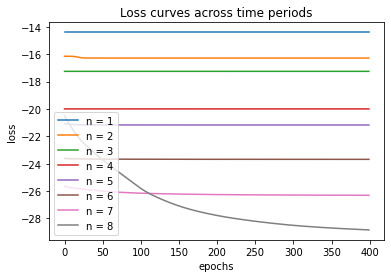

In [58]:
filtered_list = list(filter(None, loss_functions))
legend = ["n = 1", "n = 2", "n = 3", "n = 4", "n = 5", "n = 6", "n = 7", "n = 8"]

for i in range(len(filtered_list)):
  epochs = np.array([i for i in range(len(filtered_list[0]))])
  plt.plot(epochs, filtered_list[i], label='loss funciton')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(legend)
  plt.title('Loss curves across time periods')
  plt.plot()

In [59]:
print(BS.drift, BS.nb_dates, BS.maturity)
disc_factor = np.math.exp((-BS.drift) * BS.maturity /(BS.nb_dates))

payoff_ = MaxCall(100)
immediate_exercise_value = payoff_.eval(training_set[:, :, -1])
final = immediate_exercise_value

date = 5 #stock_paths.shape[2] - 2

immediate_exercise_value = payoff_.eval(training_set[:, :, date])

optimizer = optim.Adam(network.parameters())
discounted_next_values = disc_factor * (torch.from_numpy(final).double())
immediate_exercise_value = torch.from_numpy(immediate_exercise_value).double()

X_inputs = torch.from_numpy(training_set[:, :, date]).double()
print(X_inputs.shape)
print('Training set has {} instances'.format(len(X_inputs)))
display_loader = torch.utils.data.DataLoader(X_inputs, batch_size=10)
dataiter = iter(display_loader)

'''

network.train(True)
ones = torch.ones(len(discounted_next_values))
losses = []
for iteration in range(5000):
  optimizer.zero_grad()
  with torch.set_grad_enabled(True):
    outputs = network(X_inputs).reshape(-1)
    
    loss = -loss_fn(immediate_exercise_value, discounted_next_values, ones, outputs)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

'''
print("training_set shape 5 paths, 2 stocks, 11 dates", training_set.shape)
print("X_inputs 5 paths X 2 stocks", X_inputs)
print(tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=4, drop_last=False))
for batch in tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=4, drop_last=False):
  # we sample from X_inputs batches of size 4 paths
  print("batch", X_inputs[batch], range(len(X_inputs)), batch)


0.2 9 1.0
torch.Size([20, 2])
Training set has 20 instances
training_set shape 5 paths, 2 stocks, 11 dates (20, 2, 10)
X_inputs 5 paths X 2 stocks tensor([[93.0837, 93.6968],
        [96.9162, 96.0451],
        [95.9635, 96.5389],
        [90.9581, 95.0545],
        [96.5168, 98.2449],
        [96.2604, 91.9720],
        [92.4799, 96.2742],
        [94.0450, 92.8612],
        [95.5543, 98.8281],
        [92.1535, 91.8545],
        [95.7702, 96.6228],
        [95.9526, 95.3796],
        [91.6021, 94.9921],
        [94.8037, 94.6031],
        [93.6590, 93.4806],
        [92.0366, 96.6662],
        [98.0177, 94.7643],
        [98.3155, 96.4981],
        [95.7486, 92.1947],
        [94.0382, 95.0799]], dtype=torch.float64)
batch tensor([[93.0837, 93.6968],
        [93.6590, 93.4806],
        [92.0366, 96.6662],
        [92.1535, 91.8545]], dtype=torch.float64) range(0, 20) [0, 14, 15, 9]
batch tensor([[94.0382, 95.0799],
        [96.9162, 96.0451],
        [95.5543, 98.8281],
        [95.7

In [60]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f")
plt.show()

NameError: ignored

In [ ]:
for name, p in network.named_parameters():
    print(name, p.grad)

In [ ]:
# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
print('Training set has {} instances'.format(len(training_set)))
dataiter = iter(training_loader)

def train_one_epoch(epoch_index, tb_writer):

    final = MaxCall(training_set[:, :, -1])
    discounted_next_values = disc_factor * (torch.from_numpy(final).double())

    date = 5 #training_set.shape[2] - 2
    print(training_set.shape[2], date)
    immediate_exercise_value = MaxCall(training_set[:, :, date])
    immediate_exercise_value = torch.from_numpy(immediate_exercise_value).double()
    X_inputs = torch.from_numpy(training_set[:, :, date]).double()

    optimizer = optim.Adam(network.parameters())
    
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, X_inputs[4] in enumerate(training_loader):

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = network(X_inputs)

        # Compute the loss and its gradients
        loss = - loss_fn(immediate_exercise_value, discounted_next_values, ones, outputs)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    network.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    network.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = network(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(network.state_dict(), model_path)

    epoch_number += 1